The task is to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections

In [22]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Dataset field names
data_Columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "last_flag"]

# Load NSL_KDD train dataset
KDD_train = pd.read_table("KDDTrain+.txt", sep=",", names=data_Columns)
KDD_test = pd.read_table("KDDTest+.txt", sep=",", names=data_Columns)
KDD_train = KDD_train.iloc[:,:-1]
KDD_test = KDD_test.iloc[:,:-1]

KDD_test.head()

# Peak at the first 5 records.
KDD_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Data Preprocessing

Check For missing values

In [3]:
print(KDD_train.isnull().sum().sum())
print(KDD_test.isnull().sum().sum())

0
0


The training set contains no missing values. 
Drop the missing values

In [4]:
# KDD_train = KDD_train.dropna()
# KDD_train.isnull().sum().sum()

0

# Data Preprocessing

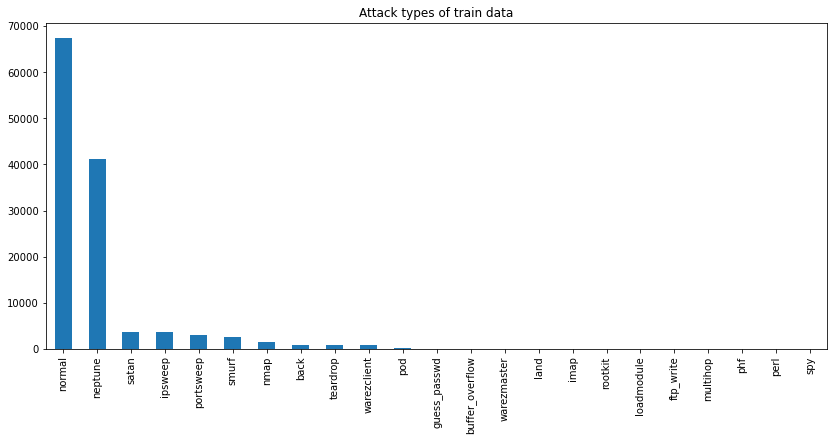

In [5]:
# Check for attack types onn train data

(KDD_train['label'].value_counts()).plot(kind='bar', figsize=(14, 6))
plt.title('Attack types of train data')
plt.show()

Map the label categories into Anomaly and normal

In [6]:
class_mapping = {'ipsweep': 'Anomaly','satan': 'Anomaly','nmap': 'Anomaly','portsweep': 'Anomaly','saint': 'Anomaly','mscan': 'Anomaly',
        'teardrop': 'Anomaly','pod': 'Anomaly','land': 'Anomaly','back': 'Anomaly','neptune': 'Anomaly','smurf': 'Anomaly','mailbomb': 'Anomaly',
        'udpstorm': 'Anomaly','apache2': 'Anomaly','processtable': 'Anomaly',
        'perl': 'Normal','loadmodule': 'Normal','rootkit': 'Normal','buffer_overflow': 'Normal','xterm': 'Normal','ps': 'Normal',
        'sqlattack': 'Normal','httptunnel': 'Normal',
        'ftp_write': 'Normal','phf': 'Normal','guess_passwd': 'Normal','warezmaster': 'Normal','warezclient': 'Normal','imap': 'Normal',
        'spy': 'Normal','multihop': 'Normal','named': 'Normal','snmpguess': 'Normal','worm': 'Normal','snmpgetattack': 'Normal',
        'xsnoop': 'Normal','xlock': 'Normal','sendmail': 'Normal',
        'normal': 'Normal'
        }

In [7]:
KDD_train['label_class'] = KDD_train['label'].apply(lambda x: class_mapping[x])
KDD_test['label_class'] = KDD_test['label'].apply(lambda x: class_mapping[x])

KDD_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,label_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,Anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,Normal


Find categorical features in the dataset

In [8]:
num_cols = KDD_train._get_numeric_data().columns
  
categorical_cols = list(set(KDD_train.columns)-set(num_cols))
categorical_cols.remove('label_class')
  
categorical_cols

['label', 'protocol_type', 'flag', 'service']

In [9]:
# 'num_outbound_cmds' column has all 0 values. Therefore, it will be removed from both train and test dataset since it is a redundant field.

KDD_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
KDD_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

### Data Correlation

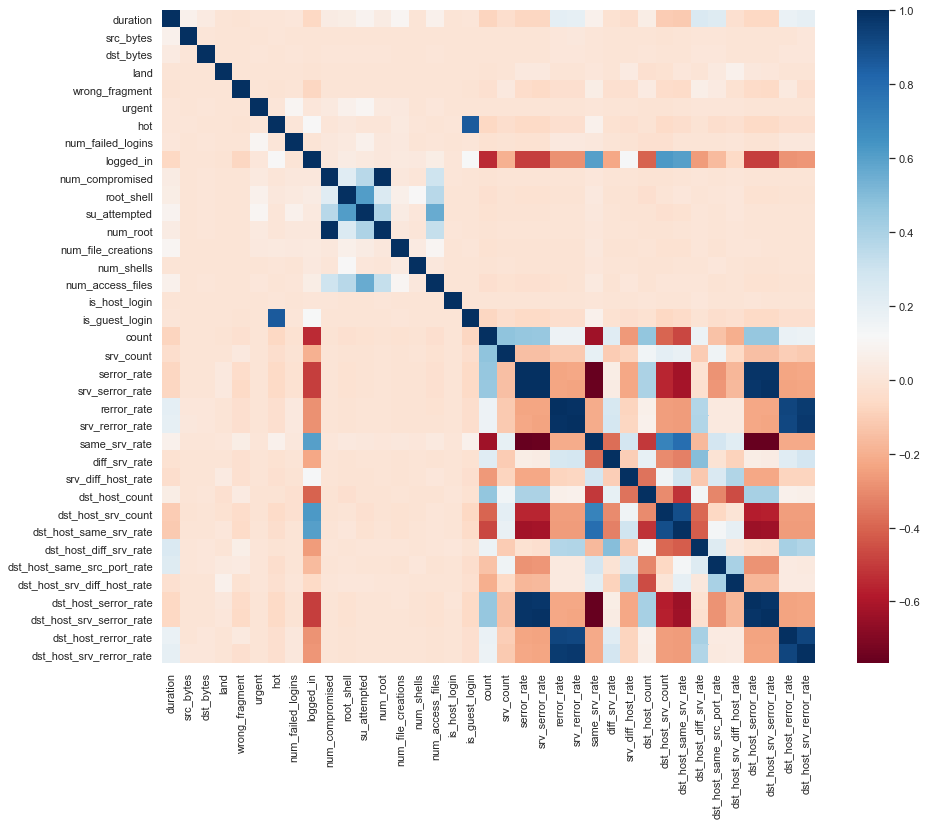

In [10]:
# Correlation heat map of train data
sns.set(rc={'figure.figsize':(15, 12)})
sns.heatmap(KDD_train.corr(), cmap='RdBu', square=True, annot=False)
plt.show()

In [23]:
KDD_train.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1) 

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,root_shell,su_attempted,num_file_creations,num_shells,num_access_files,is_host_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
duration,1.0,0.071,0.035,-0.0016,-0.0099,0.0038,0.00071,0.0095,-0.064,0.053,0.087,0.099,-0.0016,0.07,-0.00026,-0.079,-0.039,-0.07,-0.07,0.2,0.2,0.075,-0.014,-0.04,0.051,0.25,0.23,-0.027
src_bytes,0.071,1.0,0.0002,-0.00011,-0.00069,-5.9e-05,0.00029,-0.00021,-0.0034,-0.00027,-0.00019,-0.00018,-0.00013,-0.00031,-2.2e-05,-0.0052,-0.0028,-0.0032,-0.0034,0.014,0.014,0.0039,-0.00043,-0.0026,-0.0058,0.0009,0.00043,-0.0017
dst_bytes,0.035,0.0002,1.0,-6.9e-05,-0.00044,0.00025,-0.00034,0.0005,-0.0029,0.0011,0.0011,8.9e-05,-8.3e-05,0.00034,-8.4e-06,-0.0035,-0.0018,-0.0031,-0.003,0.011,0.011,0.0038,-0.0017,-0.0017,0.0025,0.011,0.012,-0.0013
land,-0.0016,-0.00011,-6.9e-05,1.0,-0.0013,-0.00011,-0.0013,-0.00038,-0.011,-0.00052,-0.00034,-0.00037,-0.00026,-0.00058,-4e-05,-0.0098,-0.005,0.022,0.023,-0.0041,-0.0053,0.0087,-0.0016,0.038,-0.025,-0.0045,0.034,0.07
wrong_fragment,-0.0099,-0.00069,-0.00044,-0.0013,1.0,-0.00069,-0.0085,-0.0024,-0.072,-0.0033,-0.0022,-0.0023,-0.0017,-0.0037,-0.00025,-0.021,0.024,-0.043,-0.057,-0.033,-0.034,0.055,-0.027,-0.026,0.041,0.06,0.037,-0.016
urgent,0.0038,-5.9e-05,0.00025,-0.00011,-0.00069,1.0,0.00029,0.098,0.0073,0.075,0.098,0.025,-0.00014,0.011,-2.2e-05,-0.0056,-0.0028,-0.0049,-0.0049,-0.0029,-0.0029,0.006,-0.0027,-0.0029,-0.0069,0.0068,0.0027,0.0052
hot,0.00071,0.00029,-0.00034,-0.0013,-0.0085,0.00029,1.0,0.0037,0.12,0.015,0.00013,0.029,0.0047,-0.002,0.001,-0.069,-0.035,-0.059,-0.059,-0.032,-0.031,0.069,-0.016,-0.027,-0.012,-0.012,-0.035,-0.025
num_failed_logins,0.0095,-0.00021,0.0005,-0.00038,-0.0024,0.098,0.0037,1.0,-0.0064,0.033,0.073,0.022,-0.0005,0.00065,-7.6e-05,-0.02,-0.0099,-0.015,-0.016,0.022,0.022,0.019,-0.0044,-0.01,-0.025,-0.0019,-0.0055,0.0033
logged_in,-0.064,-0.0034,-0.0029,-0.011,-0.072,0.0073,0.12,-0.0064,1.0,0.045,0.03,0.032,0.023,0.051,0.0035,-0.54,-0.2,-0.49,-0.49,-0.29,-0.28,0.6,-0.22,0.13,-0.4,-0.26,-0.16,-0.056
root_shell,0.053,-0.00027,0.0011,-0.00052,-0.0033,0.075,0.015,0.033,0.045,1.0,0.61,0.065,0.12,0.37,-0.0001,-0.026,-0.012,-0.018,-0.018,-0.009,-0.0094,0.028,-0.0098,-0.012,-0.03,-0.0051,0.0016,0.013


### Feature Extraction


Done from the analysis of the feature extraction using the correlation of the dataset. The ideal features are those whose correlations are above 0.6.

In [11]:
#is highly correlated with srv_serror_rate and should be ignored for analysis.
#(Correlation = 0.9993041091850098)
KDD_train.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

#(Correlation = 0.86)
KDD_train.drop('is_guest_login', axis = 1, inplace = True)
  
# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9869947924956001)
KDD_train.drop('dst_host_serror_rate', axis = 1, inplace = True)

#(Correlation = 0.62)
KDD_train.drop('dst_host_srv_count', axis = 1, inplace = True)
  
# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9821663427308375)
KDD_train.drop('dst_host_rerror_rate', axis = 1, inplace = True)
  
# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9851995540751249)
KDD_train.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)
  
# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9865705438845669)
KDD_train.drop('dst_host_same_srv_rate', axis = 1, inplace = True)

#(Correlation = 1)
KDD_train.drop('num_compromised', axis = 1, inplace = True)

 #(Correlation = 1)
KDD_train.drop('num_root', axis = 1, inplace = True)

### Selected features

In [12]:
desired_features = KDD_train[['count','dst_bytes','protocol_type','same_srv_rate', 'service','src_bytes','srv_count','label_class']]
desired_features.head()

,count,dst_bytes,protocol_type,same_srv_rate,service,src_bytes,srv_count,label_class
0,2,0,tcp,1.00,ftp_data,491,2,Normal
1,13,0,udp,0.08,other,146,1,Normal
2,123,0,tcp,0.05,private,0,6,Anomaly
3,5,8153,tcp,1.00,http,232,5,Normal
4,30,420,tcp,1.00,http,199,32,Normal


Unique features

In [13]:
desired_features['protocol_type'].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [14]:
desired_features['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [24]:
# Merge data
KDD_test = KDD_test[['count','dst_bytes','protocol_type','same_srv_rate', 'service','src_bytes','srv_count','label_class']]
data = pd.merge(desired_features,KDD_test,how='inner')

# Splitting the dataset
data.head()

,count,dst_bytes,protocol_type,same_srv_rate,service,src_bytes,srv_count,label_class
0,121,0,tcp,0.16,private,0,19,Anomaly
1,121,0,tcp,0.16,private,0,19,Anomaly
2,121,0,tcp,0.16,private,0,19,Anomaly
3,121,0,tcp,0.16,private,0,19,Anomaly
4,121,0,tcp,0.16,private,0,19,Anomaly


# Label Encoding

In [25]:
 # protocol_type feature mapping
pmap = {'icmp':0, 'tcp':1, 'udp':2}
data['protocol_type'] = data['protocol_type'].map(pmap)

In [26]:
from sklearn.preprocessing import LabelEncoder

label_Encoder = LabelEncoder()
data = data.apply(label_Encoder.fit_transform)
data.head()

,count,dst_bytes,protocol_type,same_srv_rate,service,src_bytes,srv_count,label_class
0,114,0,1,16,39,0,18,0
1,114,0,1,16,39,0,18,0
2,114,0,1,16,39,0,18,0
3,114,0,1,16,39,0,18,0
4,114,0,1,16,39,0,18,0


### Data Scalling 

In [27]:
min_max_scaler = MinMaxScaler()
# Target variable and train set
y = data['label_class']
x = data.drop(['label_class'], axis = 1)
columns_ = x.columns

scaled_data= min_max_scaler.fit_transform(x)

X = pd.DataFrame(scaled_data, columns=columns_)
X.head()

,count,dst_bytes,protocol_type,same_srv_rate,service,src_bytes,srv_count
0,0.265116,0.0,0.5,0.290909,0.722222,0.0,0.0625
1,0.265116,0.0,0.5,0.290909,0.722222,0.0,0.0625
2,0.265116,0.0,0.5,0.290909,0.722222,0.0,0.0625
3,0.265116,0.0,0.5,0.290909,0.722222,0.0,0.0625
4,0.265116,0.0,0.5,0.290909,0.722222,0.0,0.0625


### Splitting Data

In [28]:
from  sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =42)

# Modelling

Code: Importing libraries and splitting the dataset

In [32]:
from sklearn.metrics import confusion_matrix

def model_eval(y_test, pred, n,a):
    print(classification_report(y_test, pred))  
    con_mat = confusion_matrix(y_test, pred)
    print("confusion_matrix：\n", con_mat)

    classes = n
    con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    con_mat_norm = np.around(con_mat_norm, decimals=2)

    # === plot ===
    sns.set(rc={'figure.figsize':(10, 8)})
    sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
    plt.ylim(0, classes)
    plt.title('{} Confusion Matrix'.format(a))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

Train score is: 0.9859943977591037
Bernoulli Confusion Matrix
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       283
           1       0.91      0.88      0.89        24

    accuracy                           0.98       307
   macro avg       0.95      0.93      0.94       307
weighted avg       0.98      0.98      0.98       307

confusion_matrix：
 [[281   2]
 [  3  21]]


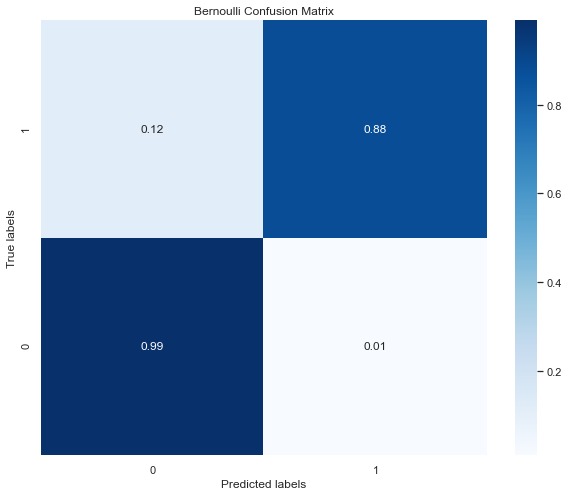

In [44]:
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
  
nbclf = BernoulliNB()
nbclf.fit(X_train, y_train.values.ravel())
y_preds = nbclf.predict(X_test)            

print("Train score is:", nbclf.score(X_train, y_train))

print('Bernoulli Confusion Matrix')

model_eval(y_test, y_preds, 2, 'Bernoulli')

Train score is: 0.9915966386554622
Train score is: 0.9915966386554622
KNeighbours Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      0.96      0.98        24

    accuracy                           1.00       307
   macro avg       1.00      0.98      0.99       307
weighted avg       1.00      1.00      1.00       307

confusion_matrix：
 [[283   0]
 [  1  23]]


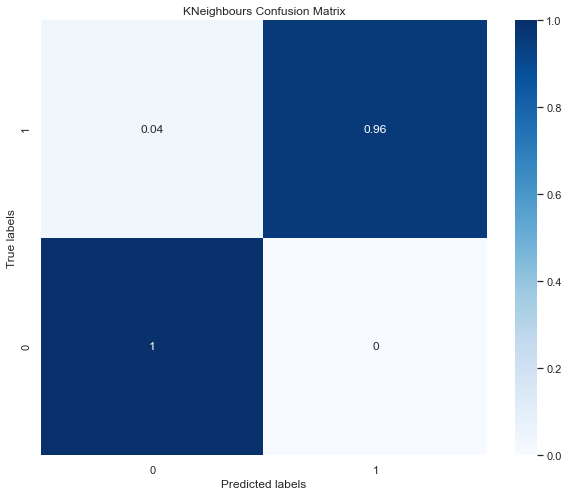

In [45]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train)  
print("Train score is:", classifier.score(X_train, y_train))
y_preds = classifier.predict(X_test)            

print("Train score is:", classifier.score(X_train, y_train))

print('KNeighbours Confusion Matrix')

model_eval(y_test, y_preds, 2,'KNeighbours')

In [37]:
from sklearn import model_selection 

# prepare models
seed = 7
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )))
# models.append(('NB', GaussianNB(priors=None,var_smoothing=1000)))
models.append(('NB', BernoulliNB()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


KNN: 0.990206 (0.013153)
NB: 0.865696 (0.148889)


In [51]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

score = []
for name, model in models:
    alg = name
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    cm1 = confusion_matrix(y_test, pred)
    recall = metrics.recall_score(y_test,pred, average='macro')*100
    precision = metrics.precision_score(y_test,pred, average='macro')*100
    f1 = metrics.f1_score(y_test,pred, average='macro')*100
    bcr = balanced_accuracy_score(y_test, pred)*100
    sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])*100
    specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])*100
    Error_r = (cm1[1,0] + cm1[1,1])/(cm1[0,0] + cm1[1,0] + cm1[1,0]+cm1[1,1])*100
    score.append((alg,cv_results.mean(),recall,precision,f1,sensitivity,specificity,Error_r,bcr))

results = pd.DataFrame(score, columns=['Model','Accuracy','Recall','Precision','F-Measure','sensitivity','specificity','Error Rate','BCR'])

print('Features Performance Evaluation')
results.T



Features Performance Evaluation


,0,1
Model,KNN,NB
Accuracy,0.990206,0.865696
Recall,97.916667,93.396643
Precision,99.823944,95.124005
F-Measure,98.847987,94.239934
sensitivity,100.0,99.293286
specificity,95.833333,87.5
Error Rate,7.792208,7.792208
BCR,97.916667,93.396643


In [49]:
results

,Model,Accuracy,Recall,Precision,F-Measure,sensitivity,specificity,Error Rate,BCR
0,KNN,0.990206,0.979167,0.998239,0.988480,1.000000,0.958333,0.077922,0.979167
1,NB,0.865696,0.933966,0.951240,0.942399,0.992933,0.875000,0.077922,0.933966


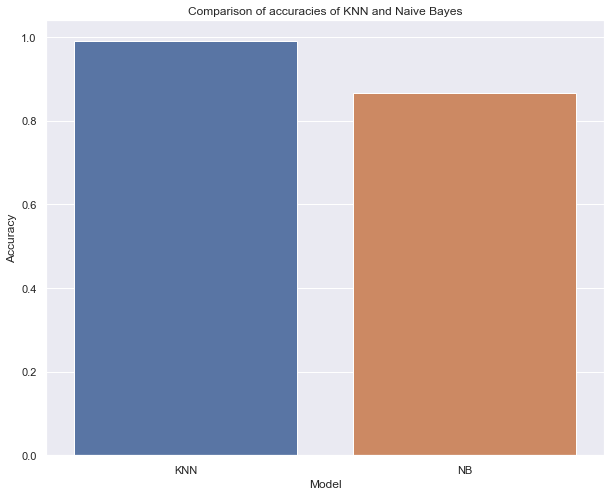

In [53]:
sns.barplot(x = results['Model'], y=results['Accuracy'], data = results)
plt.title('Comparison of accuracies of KNN and Naive Bayes')
plt.show()

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

predictions1 = classifier.predict_proba(X_test)[:,1]
predictions2 = nbclf.predict_proba(X_test)[:,1]

fpr1,tpr1, threshold = roc_curve(y_test, predictions1)
fpr2,tpr2, threshold = roc_curve(y_test, predictions2)

print('R=roc_auc_score for KNN: ',roc_auc_score(y_test,predictions1))
print('R=roc_auc_score for Naive Bayes: ',roc_auc_score(y_test,predictions2))

R=roc_auc_score for KNN:  1.0
R=roc_auc_score for Naive Bayes:  0.9643698468786808


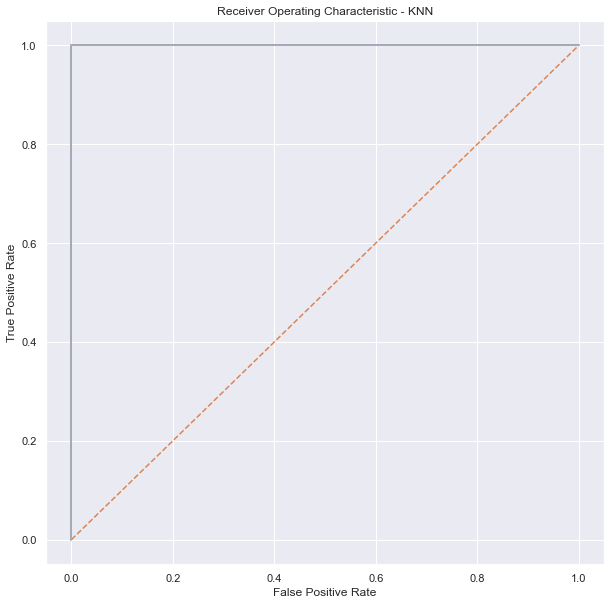

In [41]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - KNN')
plt.plot(fpr1,tpr1)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7')
plt.plot([1,1], c='.7')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

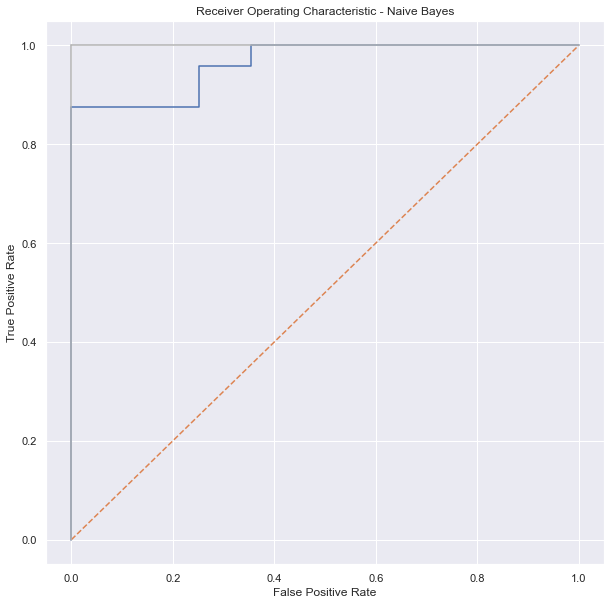

In [42]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(fpr2,tpr2)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7')
plt.plot([1,1], c='.7')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()